# Saving the categorized data

In [2]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame as df

# Load data
total_epodata=np.load('epoched_data.npy', allow_pickle=True)
ori_templet=np.load('ori_templet.npy', allow_pickle=True)


data_type=1 # type=1 is epoched by saccade, 2 is epoched by stimulus

final_cat=[]
data_cat=[]
val_cat=[]
dur_cat=[]
rejectedXY_cat=[]
for c_num in range(len(total_epodata)):

    temp_s=total_epodata[c_num,0]
    X=temp_s[0]; Y=temp_s[1]; TargetXY=[X[:,500],Y[:,500]]; tt=np.shape(X)

    cat_ori=np.zeros(tt[0])
    for a in range(len(ori_templet)):

        temp_ot=ori_templet[a,:]
        temp_ot=np.tile(temp_ot,np.size(TargetXY,axis=1))
        temp_ot=temp_ot.reshape(np.shape(TargetXY)[1],np.shape(TargetXY)[0])
        idx=np.round(TargetXY)==np.round(temp_ot.T)
        idx2=np.sum(idx, axis=0)
        idx3=idx2==2
        cat_ori[idx3]=a+1

    final_cat.append(cat_ori)

    # sorting data as orientation

    if data_type==1:
        TT=temp_s[3]
    elif data_type==2:
        TT=temp_s[5]

    VV=temp_s[2]
    DD=temp_s[4]

    idx_all = [cat_ori == i for i in range(9)]

    # spike data sorting
    data_catt=[TT[idx_all[1],:],
              TT[idx_all[2],:],
              TT[idx_all[3],:],
              TT[idx_all[4],:],
              TT[idx_all[5],:],
              TT[idx_all[6],:],
              TT[idx_all[7],:],
              TT[idx_all[8],:],
              TT[idx_all[0],:]
             ]
    data_cat.append(np.array(data_catt, dtype = object))

    # velocity data sorting
    val_catt=[VV[idx_all[1],:],
             VV[idx_all[2],:],
             VV[idx_all[3],:],
             VV[idx_all[4],:],
             VV[idx_all[5],:],
             VV[idx_all[6],:],
             VV[idx_all[7],:],
             VV[idx_all[8],:],
             VV[idx_all[0],:]
            ]
    val_cat.append(np.array(val_catt, dtype = object))

    # duration data sorting
    dur_catt=[DD[idx_all[1]],
             DD[idx_all[2]],
             DD[idx_all[3]],
             DD[idx_all[4]],
             DD[idx_all[5]],
             DD[idx_all[6]],
             DD[idx_all[7]],
             DD[idx_all[8]],
             DD[idx_all[0]]
            ]
    dur_cat.append(np.array(dur_catt, dtype = object))

    # X, Y data for rejected data
    rejectedXY_catt=np.array([X[idx_all[0],:],Y[idx_all[0],:]])
    rejectedXY_cat.append(rejectedXY_catt)

In [40]:
# here save data_cat using numpy.savez with allow_pickle=True
np.savez('spike_cat.npz', spike_cat=data_cat, allow_pickle=True)
np.savez('vel_cat.npz', vel_cat=val_cat, allow_pickle=True)
np.savez('dur_cat.npz', dur_cat=dur_cat, allow_pickle=True)

In [4]:
ori_templet.shape

(8, 2)


---
## The following should continue to linear_analy.ipynb

In [ ]:
val_cat

In [34]:
def generate_linear_model(rate_matrix, params, params0):
    """
    Generate a linear model of the rate matrix.

    Parameters:
    - rate_matrix (ndarray): Rate matrix (Trial x Time)
    - params (ndarray): Parameters (peak velocity, duration) shape (Trial x 2)
    - params0 (array-like): Grand average parameters [peak velocity, average velocity]

    Returns:
    - linmod (dict): Linear model structure containing:
        - wv0: reduced model velocity coefficients
        - wv: full model velocity coefficients
        - wr: full model duration coefficients
        - ssc: corrected PSTH for full model
        - ssc0: corrected PSTH for reduced model
        - v00: grand average peak velocity
        - r00: grand average average velocity
    """
    vpeak = np.abs(params[:][0])  # peak velocity
    sdur = np.abs(params[:][1])   # duration
    ss = rate_matrix              # rate matrix

    ss0 = np.nanmean(ss, axis=0)  # mean rate across trials
    dss = ss - ss0                # deviation from mean rate
    v0 = np.nanmean(vpeak)        # mean peak velocity
    r0 = np.nanmean(15. / sdur)   # mean average velocity

    dv = vpeak - v0
    dr = 10. / sdur - r0
    dz = np.stack((dv, dr), axis=1)  # shape (Trial, 2)

    # Full model coefficients
    cc = dz.T @ dz
    w12 = np.linalg.pinv(cc) @ dz.T @ dss  # shape (2, Time)

    wv = w12[0, :]  # velocity coefficients
    wr = w12[1, :]  # duration coefficients

    # Reduced model with only velocity
    wv0 = (dv.T @ dss) / (dv.T @ dv)  # shape (Time,)

    # Grand averages
    v00 = params0[0]
    r00 = params0[1]

    # Corrected PSTH for full model
    wc = (v00 - v0) * wv + (r00 - r0) * wr
    ssc = ss0 + wc

    # Corrected PSTH for reduced model
    wc0 = (v00 - v0) * wv0
    ssc0 = ss0 + wc0

    linmod = {
        'wv0': wv0,
        'wv': wv,
        'wr': wr,
        'ssc': ssc,
        'ssc0': ssc0,
        'v00': v00,
        'r00': r00
    }

    return linmod


In [12]:
peak = []
for a in range(np.shape(val_cat)[0]):
    M = []
    for ori in range(8):
        temp = val_cat[a][ori]
        M.append(np.max(temp,axis = 1))
        # peak[a][ori]  = np.max(temp,axis = 1)
    peak.append(M)

peak = np.array(peak, dtype = object)

In [13]:
final = []
for ori_num in range(8):
    finalp=[]
    for a in range(np.shape(data_cat)[0]):
        temp_data = data_cat[a][ori_num]
        pram = np.array([peak[a][ori_num], dur_cat[a][ori_num]])
        pram2= np.mean(pram, axis = 1)

        linmod = generate_linear_model(temp_data, pram, pram2);
        finalp.append(linmod)
    final.append(finalp)

In [14]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib import gridspec
from filter_matrix import filter_matrix

plot_data = {}
for ori_num in range(8):

    pp1, pp2, pp3, pp4, pp5 = [], [], [], [], []
    for a in range(np.shape(final)[1]):
        temp = final[ori_num][a]
        pp1.append(temp['wv0'])
        pp2.append(temp['wv'])
        pp3.append(temp['wr'])
        pp4.append(temp['ssc'])
        pp5.append(temp['ssc0'])

    # Stack and smooth
    zpp1 = filter_matrix(np.array(pp1), sigma=2)
    zpp2 = filter_matrix(np.array(pp2), sigma=2)
    zpp3 = filter_matrix(np.array(pp3), sigma=2)
    zpp4 = filter_matrix(np.array(pp4), sigma=2)
    zpp5 = filter_matrix(np.array(pp5), sigma=2)

    plot_data[ori_num] = [zpp1, zpp2, zpp3, zpp4, zpp5]

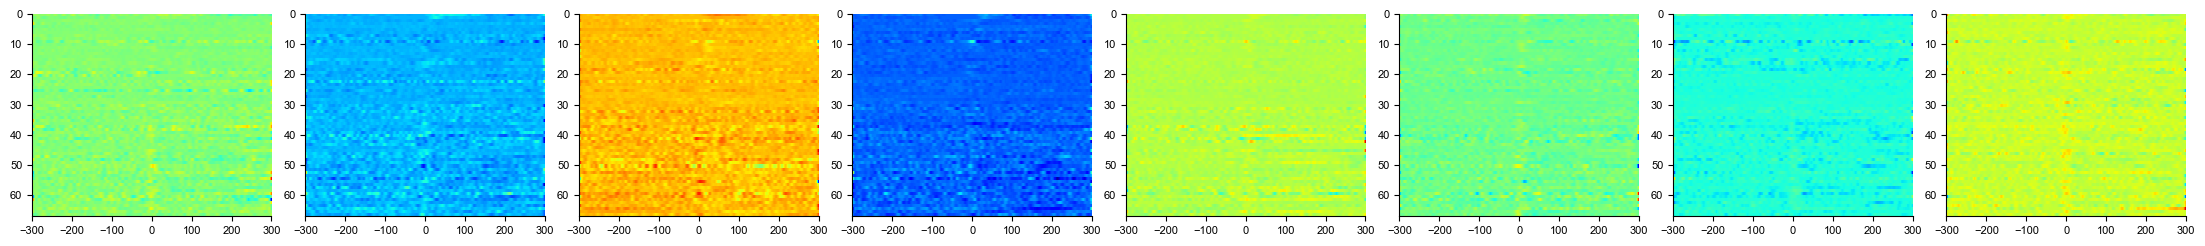

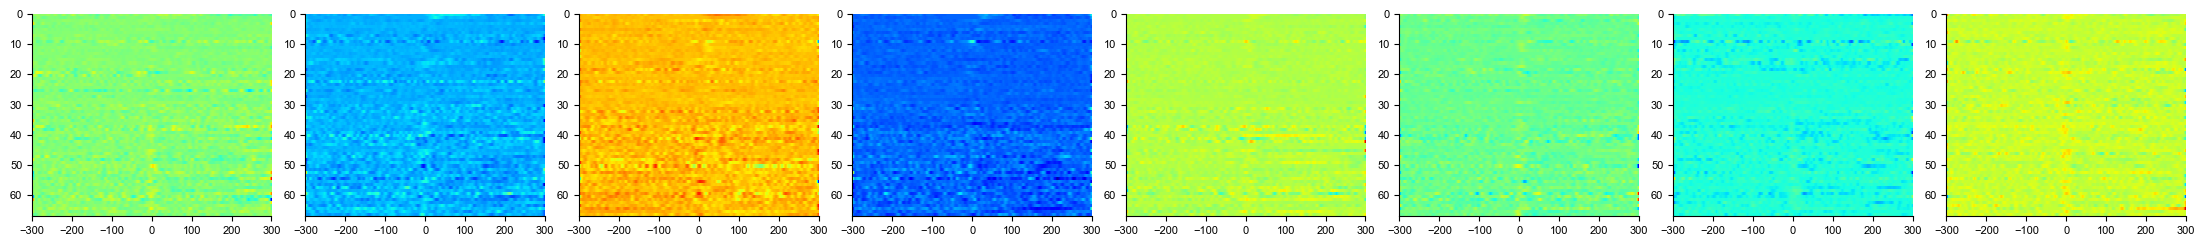

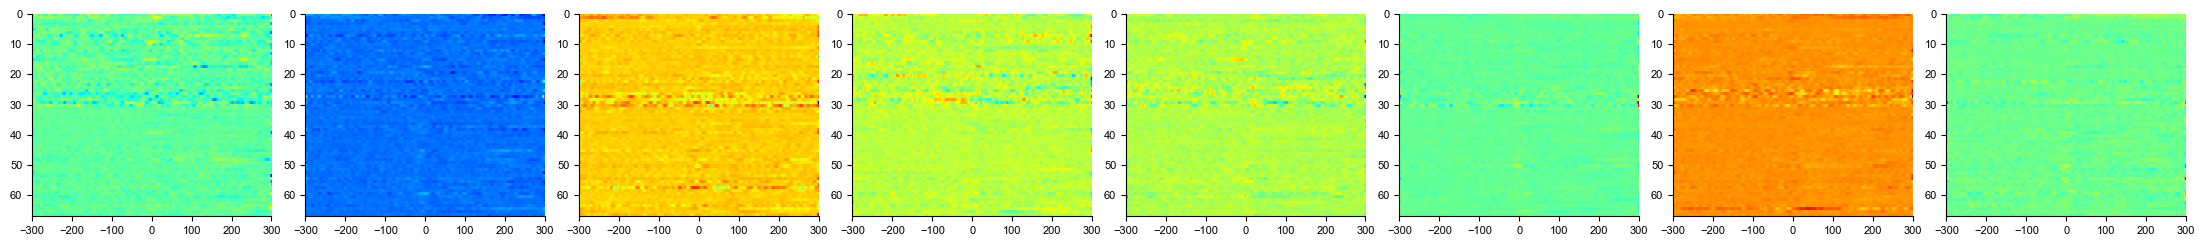

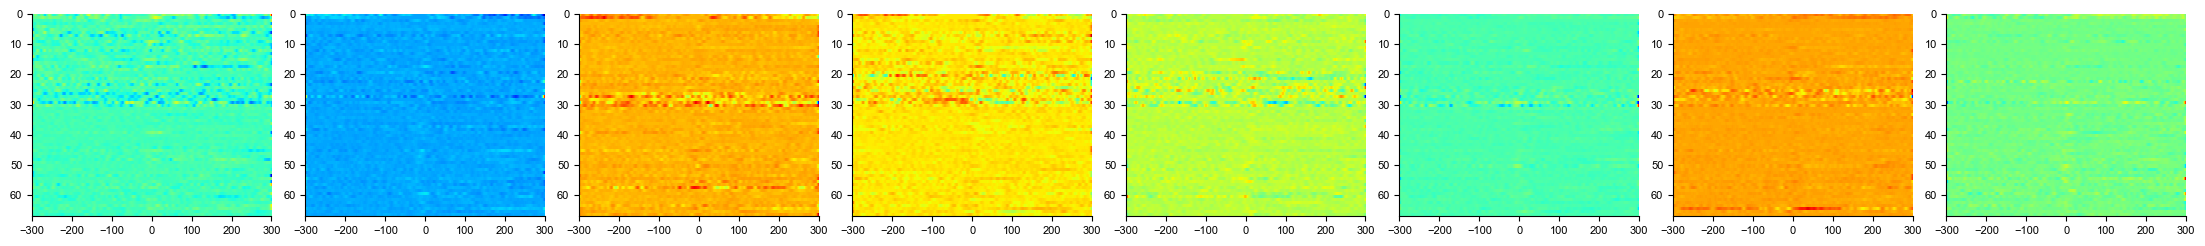

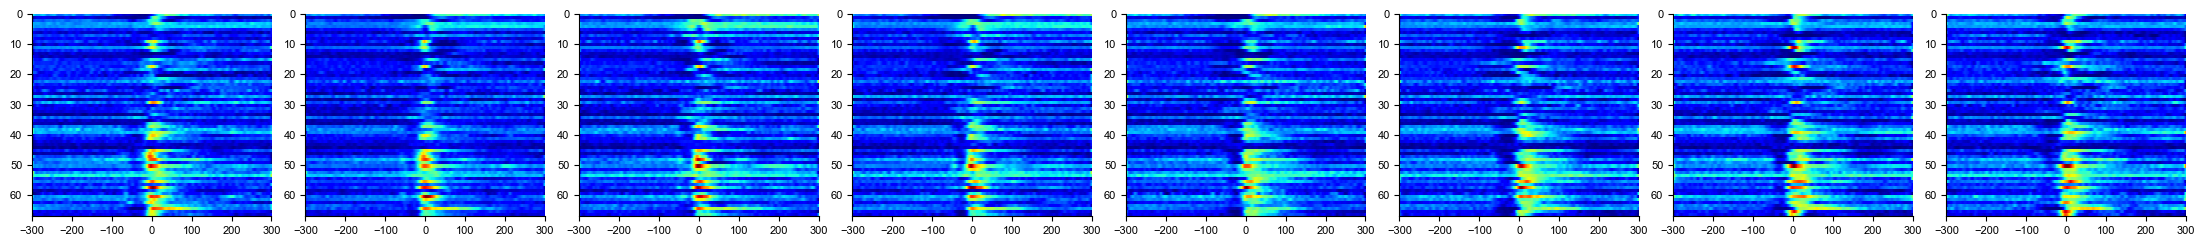

In [15]:
# Plotting 1
for b in range(5):
    fig = plt.figure(figsize=(22, 2.5))
    gs = gridspec.GridSpec(1, 8)
    for a in range(8):
        ax = fig.add_subplot(gs[0, a])
        ax.imshow(plot_data[a][b], aspect='auto', cmap='jet', interpolation='none', extent=[-300, 300, 67, 0])
    plt.tight_layout()
    plt.show()

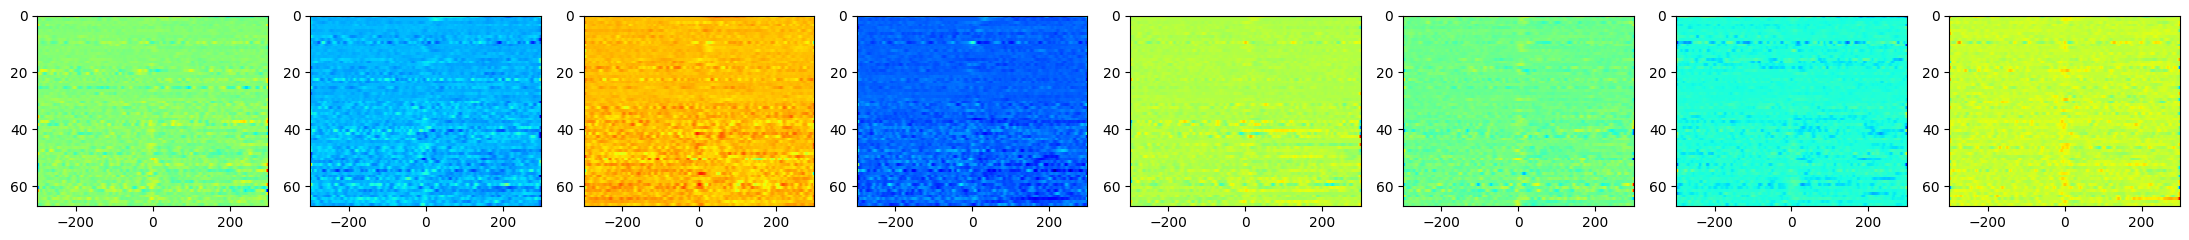

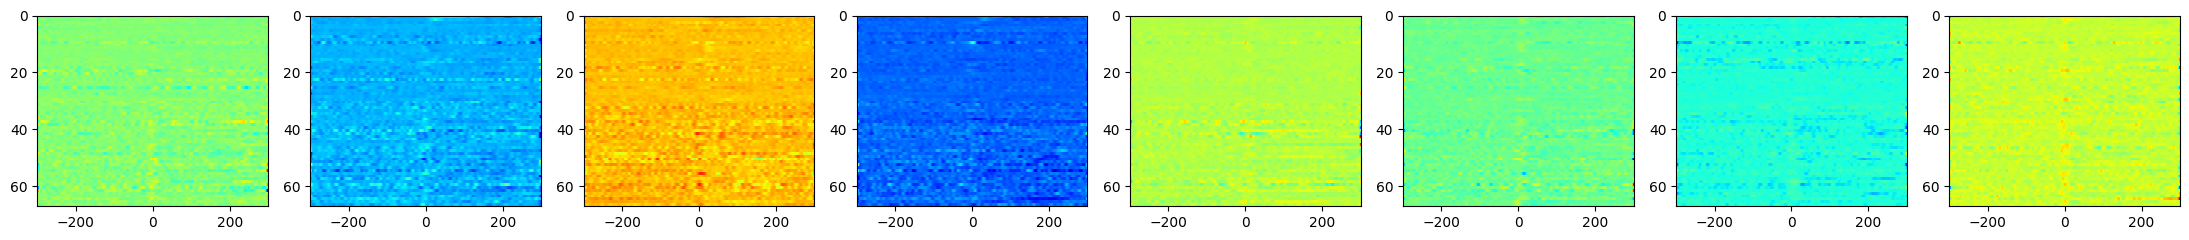

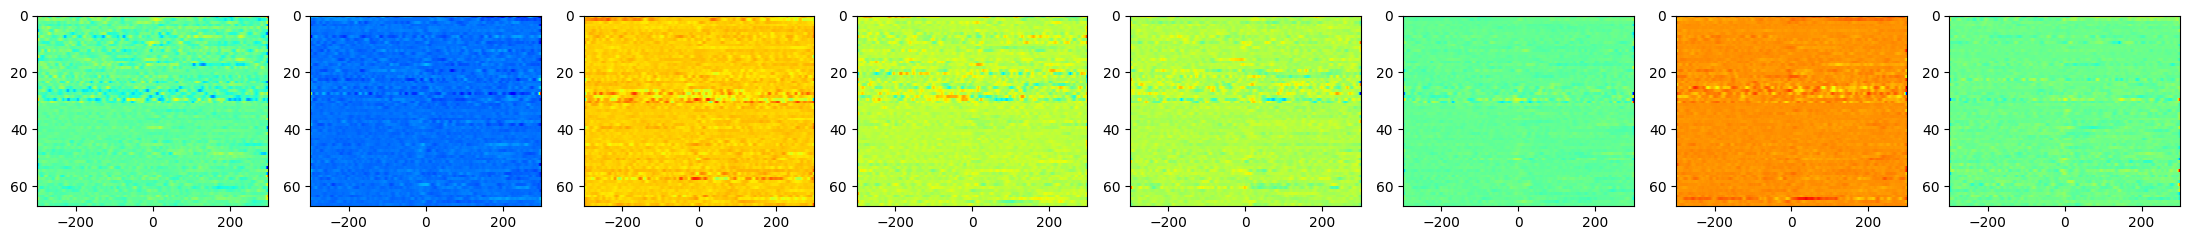

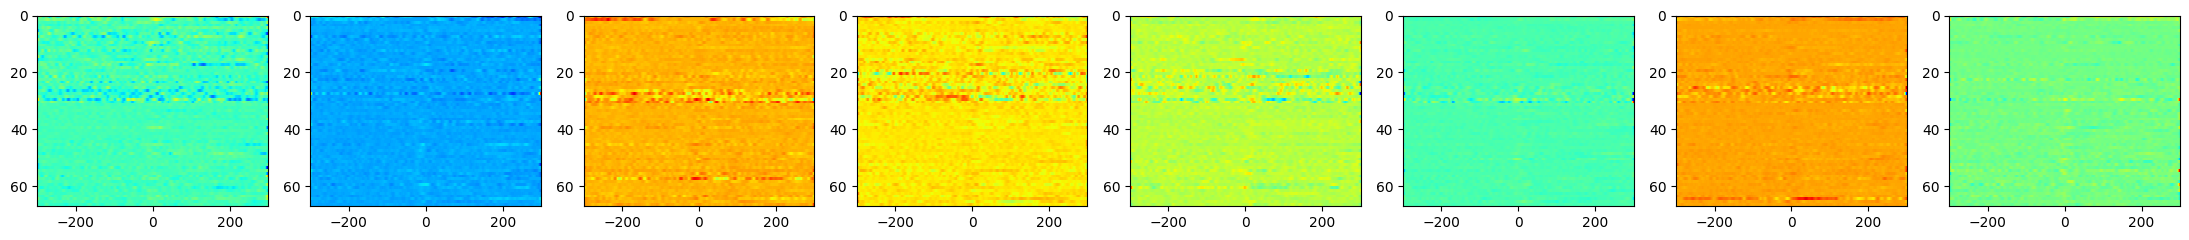

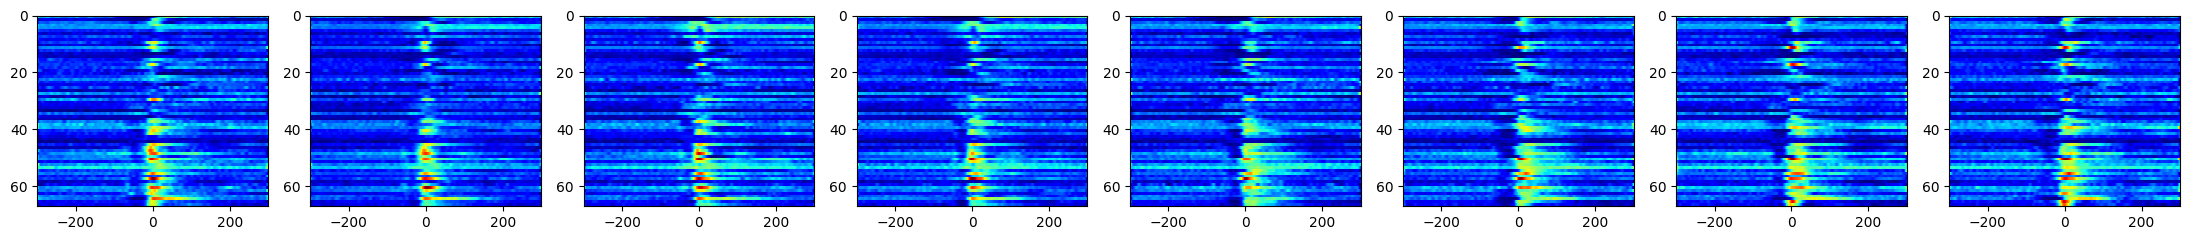

In [8]:
# Plotting 1
for b in range(5):
    fig = plt.figure(figsize=(22, 2.5))
    gs = gridspec.GridSpec(1, 8)
    for a in range(8):
        ax = fig.add_subplot(gs[0, a])
        ax.imshow(plot_data[a][b], aspect='auto', cmap='jet', interpolation='none', extent=[-300, 300, 67, 0])
    plt.tight_layout()
    plt.show()

In [1]:
# Plotting for each
# for b in range(5):
# up ur r dr down dl l ul -> right ur u ul left dl d dr [2, 1, 0, 7, 6, 5, 4, 3]
b = 0
fig = plt.figure(figsize=(22, 2.5))
gs = gridspec.GridSpec(1, 8)
time = np.arange(-300, 300)
# for a in range(8):
c = 0
for a in [2, 1, 0, 7, 6, 5, 4, 3]:
    ax = fig.add_subplot(gs[0, c])
    ax.imshow(plot_data[a][b], aspect='auto', cmap='jet', interpolation='none', extent=[-300, 300, 67, 0])
    # ax.set(xticks=np.linspace(-300, 300, 10), xticklabels=np.arange(-300, 300, 100))
    # ax.set_xticklabels([-300, 300])
    # ax.set_xlim([-300, 300])
    c = c + 1
plt.tight_layout()

plt.savefig('linear_model.jpg', dpi=300)
plt.show()

# extent=[0, 120, 10, 0]);
# ax.set(xticks=np.linspace(-300, 300, 10), xticklabels=np.arange(-300, 300, 100), yticks=[0, 10], yticklabels=[0, 1]);

NameError: name 'plt' is not defined

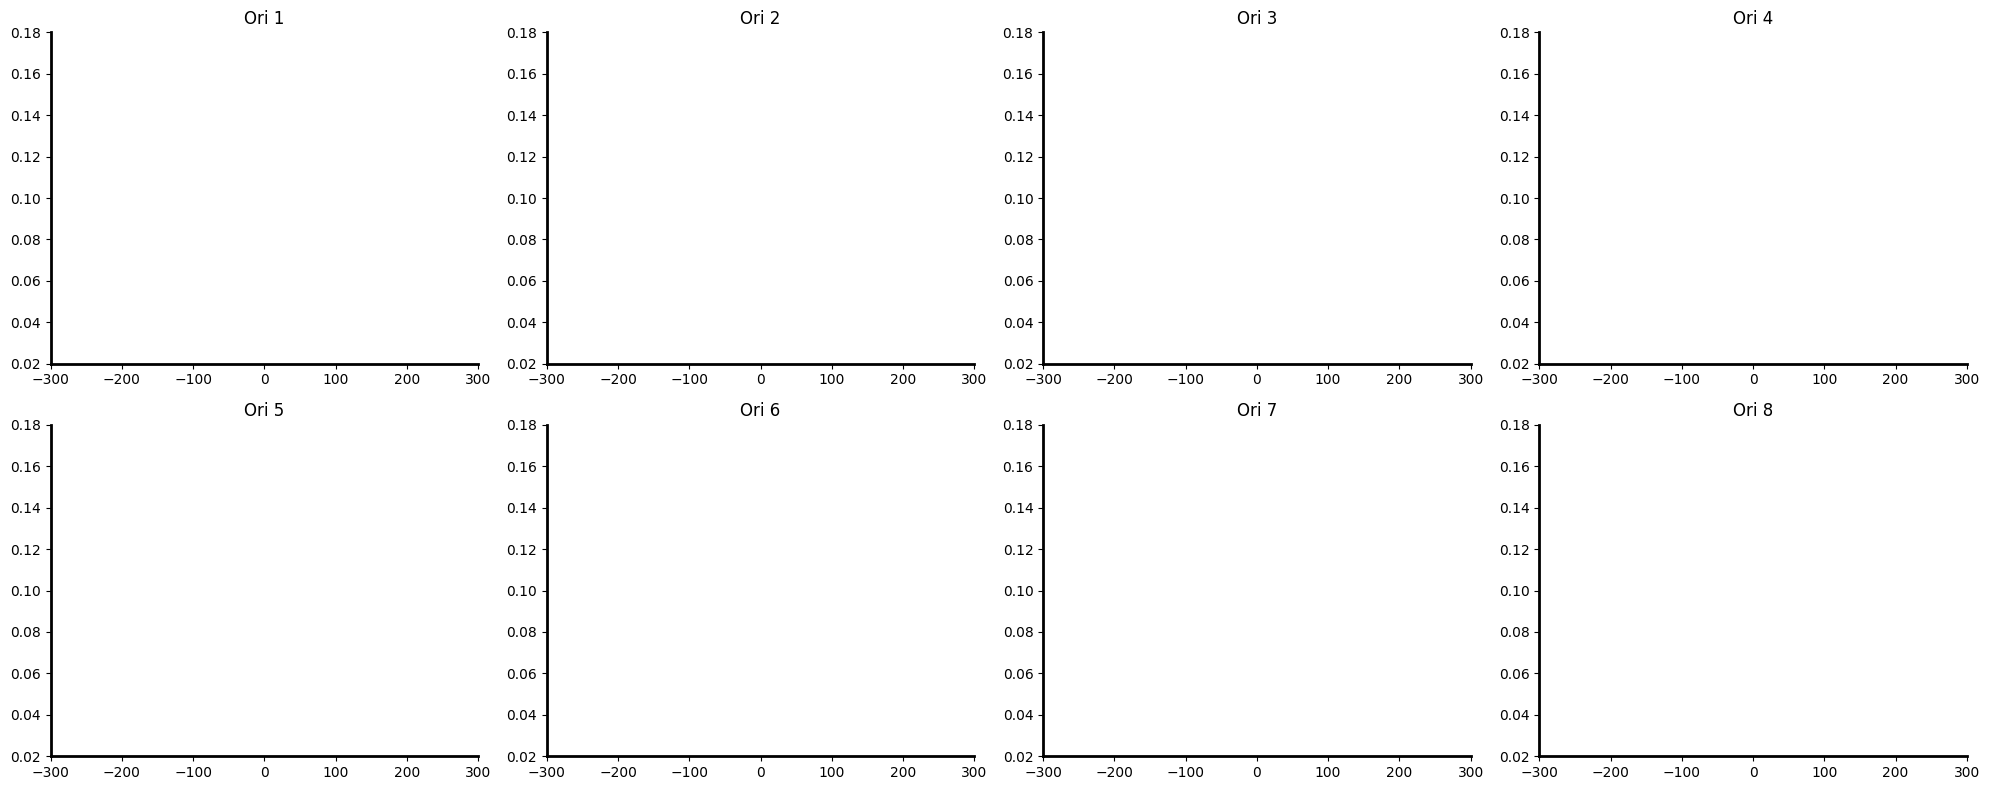

In [10]:
# Plotting 2: Mean with SEM
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
time = np.arange(-300, 300)

for ori_num in range(8):
    ax = axes[ori_num // 4, ori_num % 4]
    data = np.array(plot_data[ori_num][0])  # Using the first type of data as in original code
    mtemp = np.mean(data, axis=0)
    semtemp = np.std(data, axis=0) / np.sqrt(data.shape[0])

    ax.fill_between(time, mtemp - semtemp, mtemp + semtemp, color=(0, 0.7, 0), alpha=0.3)
    ax.plot(time, mtemp, color=(0, 0.7, 0), linewidth=1)

    ax.set_xlim([-300, 300])
    ax.set_ylim([0.02, 0.18])
    ax.set_title(f'Ori {ori_num + 1}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

plt.tight_layout()
plt.show()

In [ ]:
%% plotting

plot_data={};
for ori_num=1:8;

    pp1=[];
    pp2=[];
    pp3=[];
    pp4=[];
    pp5=[];
    for a=1:size(final,1);
        temp=final{a, ori_num};
        temp1=temp.wv0;
        temp2=temp.wv;
        temp3=temp.wr;
        temp4=temp.ssc;
        temp5=temp.ssc0;

        pp1=[pp1;temp1;];
        pp2=[pp2;temp2;];
        pp3=[pp3;temp3;];
        pp4=[pp4;temp4;];
        pp5=[pp5;temp5;];
    end

    %smoothing
    zpp1=filter_matrix(pp1', 'sigma', 2)';
    zpp2=filter_matrix(pp2', 'sigma', 2)';
    zpp3=filter_matrix(pp3', 'sigma', 2)';
    zpp4=filter_matrix(pp4', 'sigma', 2)';
    zpp5=filter_matrix(pp5', 'sigma', 2)';

    plot_data{ori_num,1}=zpp1;
    plot_data{ori_num,2}=zpp2;
    plot_data{ori_num,3}=zpp3;
    plot_data{ori_num,4}=zpp4;
    plot_data{ori_num,5}=zpp5;
end


%% plotting

for b=1:5;
    figure;
    for a=1:8;
        subplot(1,8,a)
        imagesc(plot_data{a,b})
    end

    set(gcf,'OuterPosition', [3, 270, 2200, 200])
    tightfig
end


%%
figure
for ori_num=1:8;

    subplot(2,4,ori_num)

    set(gcf,'color','w')
    set(gca,'linewidth',2);

    mtemp=mean(plot_data{ori_num});
    semtemp = std(plot_data{ori_num})/sqrt(length(plot_data{ori_num}));
    time= -300:300-1;
    h= boundedline(time, mtemp, semtemp, 'alpha', 'cmap', [0 0.7 0], 'transparency', 0.3)

    h.LineWidth = 1;
    xlim([-300 300]); ylim([0.02 0.18]);
end

set(gcf,'OuterPosition', [3, 270, 2000, 800])
tightfig

%
% % GLM regression
% Predictors(:,1)=(squareform(visMat))';
% Predictors(:,2)=(squareform(magMat))';
%
% % normalize matrices
% Predictors_zscore(:,1)=cosmo_normalize(Predictors(:,1),'zscore');
% Predictors_zscore(:,2)=cosmo_normalize(Predictors(:,2),'zscore');
% Predictors_intercept=[ones(size(Predictors_zscore,1),1) Predictors_zscore];
%
% % get betas
% betas = Predictors_zscore \ DM_timepoint_zscore;
% betas_intercept = Predictors_intercept \ DM_timepoint_zscore;
%
% Betas_Vis(s,t)=betas_intercept(2); %first element is a constant, starting from 2 are predictor betas
% Betas_Mag(s,t)=betas_intercept(3);